In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.api import VAR
from copy import copy
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.stattools import durbin_watson
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline



<h3>Условие задачи:

Представлена динамика уровня дефолта по некоторому сегменту заемщиков банка за 2009-2019 гг. <br>
Уровень дефолта на каждую дату = Число компаний, допустивших дефолт в течение 12 месяцев после этой даты /
Число недефолтных компаний на дату <br>
<br>
Необходимо сформировать список из 4-5 макроэкономических факторов, которые гипотетически могут влиять
на уровень дефолта и построить модель,
предсказывающую уровень дефолтов, получив уравнение регрессии достаточного качества. <br>
<br>
Затем нужно найти прогнозы изменения выбранных макрофакторов на 2021-2022 гг. и на их основе
спрогнозировать значения уровня дефолта.


<h3>I. Обзор анализируемых временных рядов

Рассматриваемый период: 06.2009-12.2019 <br>
<br>
Исходные данные по выбранным макрофакторам и уровню дефолтов представлены в следующем виде:

In [2]:
data = pd.read_csv('data/zadanie.csv', parse_dates=['Date'],index_col=0)
start_date = '06-01-2009'
end_date = '12-01-2019'
data = data.loc[start_date : end_date]
df = copy(data)

Переменные: зависимая - уровень дефолтов (DR), <br>
объясняющие - валютный курс (USDRUR), темп роста индустриального производства (IP), уровень инфляции (CPI),
индекс цен на жилую недвижимсть (HPI), уровень безработицы (UR), спред процентных ставок по кредитам
(краткосрочные - долгосрочные) (IRS), темп роста ВВП, year-on-year (GDP)

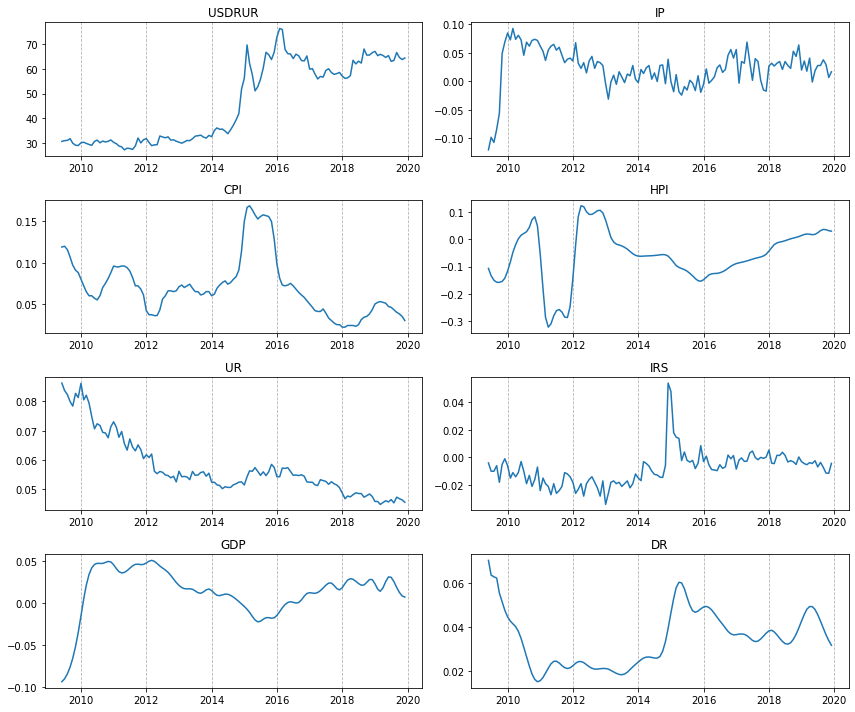

In [3]:
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(12,10))
for i, ax in enumerate(axes.flatten()):
    try:
        graph = df[df.columns[i]]
        ax.plot(graph)
        ax.set_title(df.columns[i])
        ax.grid(axis = 'x', linestyle='--', color='k', alpha=0.3)
    except IndexError:
        print("")
plt.tight_layout()

In [4]:
df.info()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127 entries, 2009-06-01 to 2019-12-01
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   USDRUR  127 non-null    float64
 1   IP      127 non-null    float64
 2   CPI     127 non-null    float64
 3   HPI     127 non-null    float64
 4   UR      127 non-null    float64
 5   IRS     127 non-null    float64
 6   GDP     127 non-null    float64
 7   DR      127 non-null    float64
dtypes: float64(8)
memory usage: 8.9 KB


<h3>II. Тест причинной связи и корреляции временных рядов

Таблица коэффициентов корреляции

<AxesSubplot:>

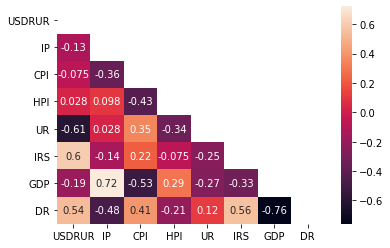

In [5]:
df_w_date = pd.DataFrame(data)

corr = df_w_date.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot=True, mask=mask)

GDP и IP имеют высокую парную корреляцию (>0,7). <br>
Использовать их совместно в будущей модели нежелательно.

In [6]:
df = copy(df.drop(columns=['IP']))


Тест Грэнджера на причинность <br>
<br>
Для наличия причинной связи в тесте важно, чтобы предшествующие значения «причины» (X) оказывали
ощутимое влияние на будущие значения «следствия» (Y) и притом прошлые значения «следствия» (Y)
не оказывали существенного влияния на будущие значения «причины» (X). <br>
Это происходит при p_value < p_крит (0,05), см. ниже:

In [7]:
maxlag = 12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test=test, verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)

,USDRUR_x,CPI_x,HPI_x,UR_x,IRS_x,GDP_x,DR_x
USDRUR_y,1.0000,0.0023,0.9127,0.0451,0.0000,0.5010,0.0000
CPI_y,0.0035,1.0000,0.0000,0.0736,0.0007,0.0289,0.0000
HPI_y,0.8239,0.0001,1.0000,0.0209,0.3300,0.0000,0.1756
UR_y,0.0133,0.0000,0.0003,1.0000,0.1225,0.0003,0.0000
IRS_y,0.0286,0.1590,0.5998,0.1332,1.0000,0.2203,0.0008
GDP_y,0.0030,0.0027,0.0054,0.0000,0.0585,1.0000,0.0000
DR_y,0.0001,0.0211,0.2114,0.0000,0.0000,0.0000,1.0000


HPI обладает слабой причинной связью с DR, поэтому также будет исключен из дальнейшего рассмотрения.

In [8]:
df = copy(df.drop(columns=['HPI']))



<h3>III. Тест на стационарность

Тест Дики Фуллера на исходных временных рядах <br>
<br>
Стационарность или постоянство — свойство процесса не менять свои характеристики, не изменять распределение
вероятности при смещении во времени. <br>
Любые стационарные данные могут быть аппроксимированы (смоделированы) моделями ARMA. <br>
При p < p_крит временной ряд признается стационарным.

In [9]:
for i in range(len(df.columns)):
    print(str(df.columns[i]))
    result = adfuller(df.iloc[:,i])
    print('p-value: %f' % result[1])
    if result[1] <= 0.05:
        print('Stationary at the 95% confidence level')

USDRUR
p-value: 0.842071
CPI
p-value: 0.467691
UR
p-value: 0.085313
IRS
p-value: 0.000891
Stationary at the 95% confidence level
GDP
p-value: 0.268750
DR
p-value: 0.588901


Графики функций автокорреляции и частичной автокорреляции

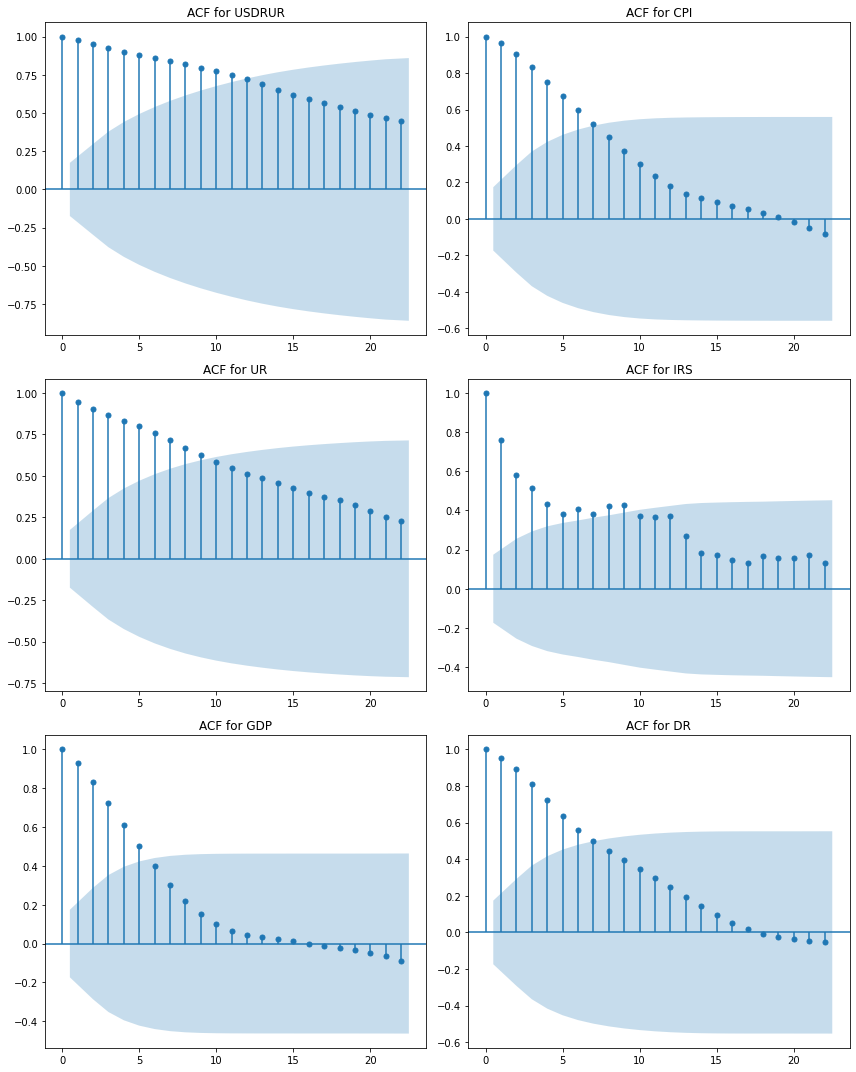

In [10]:
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(12,15))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    plot_acf(data, ax=axes[i//2][i%2])
    ax.set_title('ACF for '+df.columns[i])
plt.tight_layout()

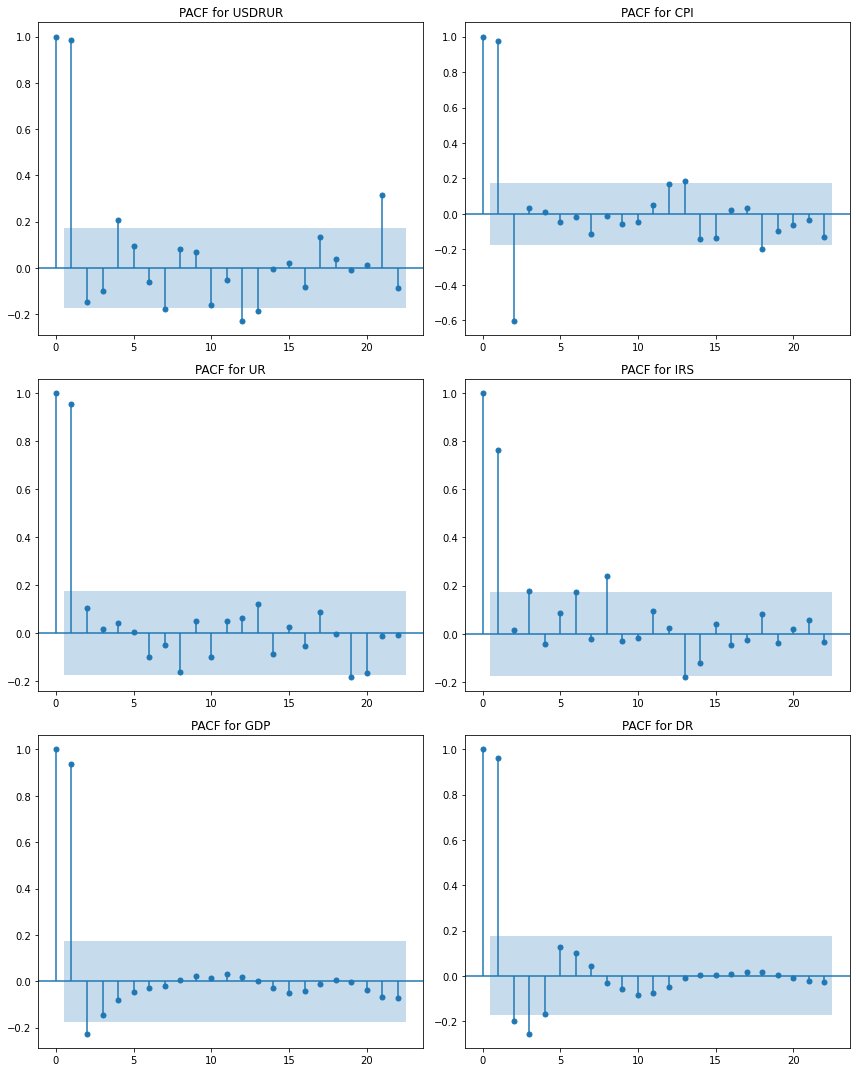

In [11]:
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(12,15))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    plot_pacf(data, ax=axes[i//2][i%2])
    ax.set_title('PACF for '+df.columns[i])
plt.tight_layout()



<h3>IV. Трансформация рядов: <br>
нормализация, дифференциация, стабилизация дисперсии

In [12]:
df_std_by_year = copy(df)
normalized_df = copy(df)
diffed_df = copy(df)
diffed_df_1 = copy(df)
stabilized_df = copy(df)

In [13]:
for i in df:
    # normalized
    avg, std = df[i].mean(), df[i].std()
    normalized_df[i] = (df[i] - avg) / std
    # diffed
    diffed_df[i] = normalized_df[i].diff().fillna(normalized_df[i].mean())

diffed_df_1['GDP'] = copy(diffed_df['GDP'])
diffed_df['GDP'] = diffed_df['GDP'].diff().fillna(diffed_df['GDP'].mean())
# stabilized_df = copy(diffed_df)
for i in df:
    # stabilized
    std_by_year = diffed_df[i].groupby(diffed_df[i].index.year).std()
    df_std_by_year[i] = diffed_df[i].index.map(lambda d: std_by_year.loc[d.year])
    stabilized_df[i] = diffed_df[i] / df_std_by_year[i]

Продемонстрируем ряды, их графики и тест Дики Фуллера после трансформации

In [14]:
print(stabilized_df)

                  USDRUR           CPI            UR           IRS       GDP  \
Date                                                                           
2009-06-01  2.150843e-15  8.684974e-15 -5.999612e-17  1.660092e-16  0.922158   
2009-07-01  3.518147e-01  2.382368e-01 -1.055211e+00 -7.542206e-01  3.945142   
2009-08-01  1.371886e-01 -9.529471e-01 -5.783786e-01  0.000000e+00  2.720974   
2009-09-01  8.202637e-01 -2.144131e+00 -1.012187e+00  5.028138e-01  2.920819   
2009-10-01 -2.188087e+00 -2.382368e+00 -6.603363e-01 -1.508441e+00  2.746823   
...                  ...           ...           ...           ...       ...   
2019-08-01  2.384889e-01 -9.281669e-01 -1.099078e+00  9.533625e-01 -1.161728   
2019-09-01  2.105940e+00 -9.281669e-01  1.911194e+00 -1.040032e+00 -0.452311   
2019-10-01 -1.302329e+00 -6.187779e-01 -5.059201e-01 -1.184481e+00  0.237878   
2019-11-01 -5.687346e-01 -9.281669e-01 -4.121232e-01 -5.777955e-02  0.439570   
2019-12-01  4.170107e-01 -1.546945e+00 -

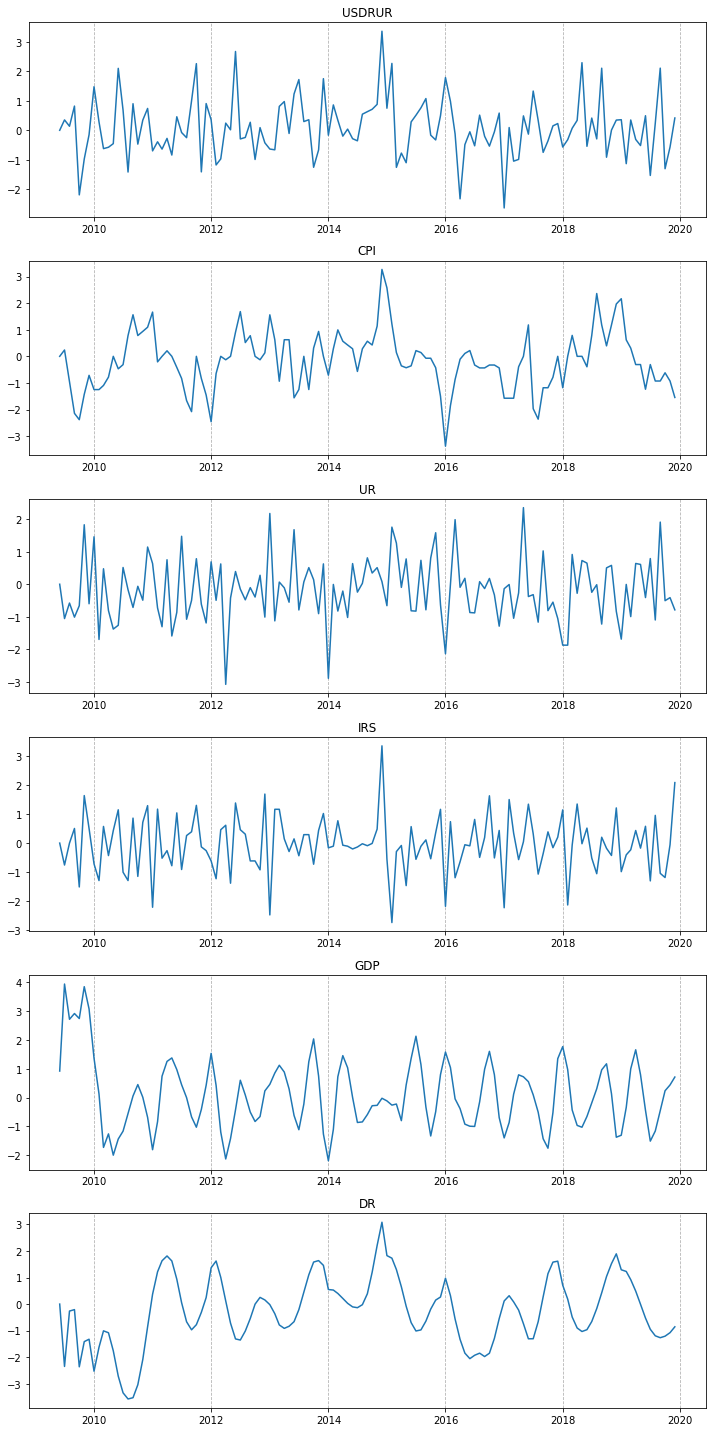

In [15]:
fig, axes = plt.subplots(nrows=len(stabilized_df.columns),figsize=(10,20))
for i, ax in enumerate(axes.flatten()):
    graph = stabilized_df[stabilized_df.columns[i]]
    ax.plot(graph)
    ax.set_title(stabilized_df.columns[i])
    ax.grid(axis = 'x', linestyle='--', color='k', alpha=0.3)
plt.tight_layout()

In [16]:
for i in range(len(stabilized_df.columns)):
    print(str(stabilized_df.columns[i]))
    result = adfuller(stabilized_df.iloc[:,i])
    print('p-value: %f' % result[1])
    if result[1] <= 0.05:
        print('Stationary at the 95% confidence level')



USDRUR
p-value: 0.000000
Stationary at the 95% confidence level
CPI
p-value: 0.003305
Stationary at the 95% confidence level
UR
p-value: 0.000000
Stationary at the 95% confidence level
IRS
p-value: 0.000000
Stationary at the 95% confidence level
GDP
p-value: 0.000346
Stationary at the 95% confidence level
DR
p-value: 0.000225
Stationary at the 95% confidence level


<h3>V. Поиск оптимального порядка VAR и обучение модели

Обучение модели происходит на периоде 06.2009-02.2019. <br>
Тестовый набор данных - последние 9 месяцев наблюдений (04-12.2019).

In [17]:
n = 9
df_no_HPI = copy(stabilized_df)
train = df_no_HPI[0:-n]
test = df_no_HPI[-n:]
train

,USDRUR,CPI,UR,IRS,GDP,DR
Date,,,,,,
2009-06-01,2.150843e-15,8.684974e-15,-5.999612e-17,1.660092e-16,0.922158,1.306302e-15
2009-07-01,3.518147e-01,2.382368e-01,-1.055211e+00,-7.542206e-01,3.945142,-2.347977e+00
2009-08-01,1.371886e-01,-9.529471e-01,-5.783786e-01,0.000000e+00,2.720974,-2.617958e-01
2009-09-01,8.202637e-01,-2.144131e+00,-1.012187e+00,5.028138e-01,2.920819,-2.077543e-01
2009-10-01,-2.188087e+00,-2.382368e+00,-6.603363e-01,-1.508441e+00,2.746823,-2.362043e+00
...,...,...,...,...,...,...
2018-11-01,8.016841e-03,1.180833e+00,5.801649e-01,-4.255798e-01,0.134901,1.524178e+00
2018-12-01,3.462758e-01,1.968055e+00,-8.321411e-01,1.209542e+00,-1.376208,1.892848e+00
2019-01-01,3.586200e-01,2.165723e+00,-1.687958e+00,-9.822523e-01,-1.307492,1.292484e+00


Поиск оптимального порядка исходя из информационных критериев

In [18]:
model = VAR(train)
order = model.select_order(maxlags=12)
order.summary()

,AIC,BIC,FPE,HQIC
0,0.3928,0.5436,1.481,0.4539
1,-2.038,-0.9830,0.1304,-1.611
2,-4.200,-2.240*,0.01511*,-3.405*
3,-4.072,-1.207,0.01745,-2.911
4,-3.920,-0.1509,0.02095,-2.392
5,-4.031,0.6425,0.01973,-2.137
6,-3.799,1.779,0.02691,-1.538
7,-3.921,2.562,0.02667,-1.294
8,-3.746,3.641,0.03722,-0.7518
9,-3.850,4.442,0.04162,-0.4895


Выберем порядок VAR(p=4). Большая часть критериев указывают на модели меньших порядков (минимизированы при p=2).<br>
С учетом количества переменных критерий BIC является предпочтительным. <br>
На выбор невысокого порядка указывает также статистика Дарбина Уотсона (см. ниже). <br>
Однако выбор p = 4 сделан исходя из существенности оценок коэффицентов выбранных макрофакторов при прогнозировании DR.

Статистика модели VAR(4)

In [19]:
model_fit = model.fit(maxlags=4)
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 21, Jun, 2021
Time:                     11:12:10
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   0.651216
Nobs:                     114.000    HQIC:                  -1.48790
Log likelihood:          -652.458    FPE:                  0.0547160
AIC:                     -2.94904    Det(Omega_mle):       0.0166516
--------------------------------------------------------------------
Results for equation USDRUR
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.224497         0.115135            1.950           0.051
L1.USDRUR        -0.049807         0.121341           -0.410           0.681
L1.CPI            0.047020         0.123563            0.381           0.70

Графики функций автокорреляции остатков модели. Важным является их нахождение внутри доверительных интервалов.

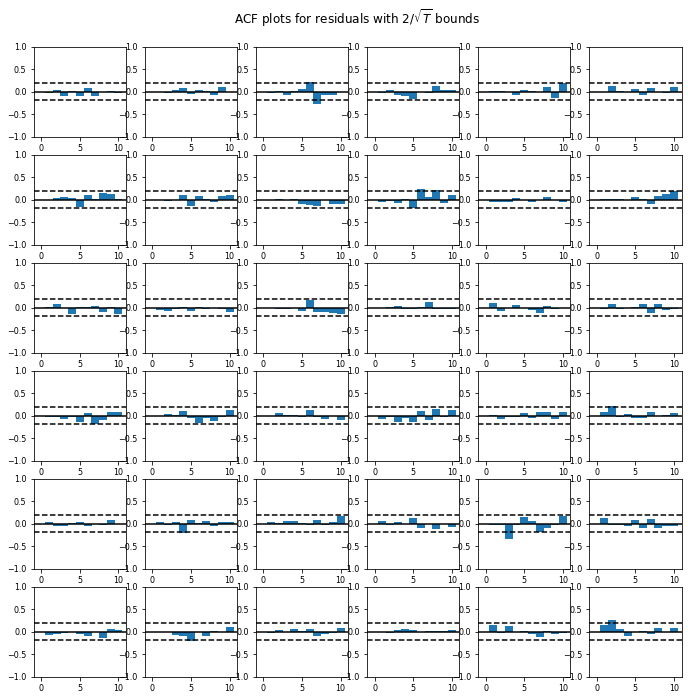

In [20]:
model_fit.plot_acorr()
plt.show()


Статистика Дарбина Уотсона (проверка автокорреляции остатков модели) при p = 4 <br>
Чем ближе коэффициенты корреляции к 2, тем меньше связи в остатках. Нормальные значения: 1.5-2.5. <br>
Выбранная спецификация модели обладает хорошим качеством.

In [21]:
def adjust(val, length= 6): return str(val).ljust(length)

In [22]:
print("Model 1")
for col, val in zip(df_no_HPI.columns, durbin_watson(model_fit.resid)):
    print(adjust(col), ':', round(val, 2))


Model 1
USDRUR : 2.05
CPI    : 2.01
UR     : 1.97
IRS    : 2.12
GDP    : 2.04
DR     : 1.67


Функции обратной трансформации

In [23]:
def stab_inv(std_series, stabilized_series):
    diffed_series = std_series * stabilized_series
    return diffed_series

def diff_inv(first_value_series, diffed_series):
    normalized_series = np.r_[first_value_series[0], diffed_series[1:]].cumsum().astype('float64')
    return normalized_series

def norm_inv(initial_series, normalized_series):
    avg, std = initial_series.mean(), initial_series.std()
    series = normalized_series * std + avg
    return series

In [24]:
diffed_df_inv = copy(df)
normalized_df_inv = copy(df)
df_inv = copy(df)

In [25]:
for i in stabilized_df:
    diffed_df_inv[i] = stab_inv(df_std_by_year[i], stabilized_df[i])
    normalized_df_inv[i] = diff_inv(normalized_df[i], diffed_df_inv[i])

normalized_df_inv['GDP'] = diff_inv(diffed_df_1['GDP'], diffed_df_inv['GDP'])
normalized_df_inv['GDP'] = diff_inv(normalized_df['GDP'], normalized_df_inv['GDP'])

for i in stabilized_df:
    df_inv[i] = norm_inv(df[i], normalized_df_inv[i])
print(df_inv)



             USDRUR    CPI        UR     IRS       GDP        DR
Date                                                            
2009-06-01  30.7441  0.119  0.086256 -0.0040 -0.093971  0.070145
2009-07-01  31.0385  0.120  0.083749 -0.0100 -0.090556  0.063437
2009-08-01  31.1533  0.116  0.082376 -0.0100 -0.084786  0.062689
2009-09-01  31.8397  0.107  0.079971 -0.0060 -0.076486  0.062095
2009-10-01  30.0087  0.097  0.078403 -0.0180 -0.065809  0.055346
...             ...    ...       ...     ...       ...       ...
2019-08-01  63.4172  0.043  0.045412 -0.0036  0.025937  0.042526
2019-09-01  66.6235  0.040  0.047352 -0.0072  0.018987  0.039387
2019-10-01  64.6407  0.038  0.046838 -0.0113  0.012993  0.036389
2019-11-01  63.7748  0.035  0.046420 -0.0115  0.008766  0.033720
2019-12-01  64.4097  0.030  0.045620 -0.0043  0.007411  0.031599

[127 rows x 6 columns]


<h3>VI. Проверка предсказательной силы модели на тестовом сете

In [26]:
test = copy(df_inv[-n:])

Функция прогнозирования и возврата к изначальному масштабу данных

In [27]:
def forecast(model_fitted, df_train, df_test):
    lag_order = model_fitted.k_ar
    forecast_input = df_train.values[-lag_order:]

    fc = model_fitted.forecast(y=forecast_input, steps=n)
    df_forecast = pd.DataFrame(fc, index=df_test.index[-n:], columns=df_test.columns + '_transf')

    diffed_df_inv_fc = copy(df_test)
    normalized_df_inv_fc = copy(df_test)
    df_forecast_inv_fc = copy(df_test)

    for i in df_test:
        diffed_df_inv_fc[i] = stab_inv(df_std_by_year[i], df_forecast[i+'_transf'])
        normalized_df_inv_fc[i] = diff_inv(normalized_df[i][-n:], diffed_df_inv_fc[i])

    if 'HPI' in df_test.columns:
        normalized_df_inv_fc['HPI'] = diff_inv(diffed_df_1['HPI'], diffed_df_inv_fc['HPI'])
        normalized_df_inv_fc['HPI'] = diff_inv(normalized_df['HPI'], normalized_df_inv_fc['HPI'])

    normalized_df_inv_fc['GDP'] = diff_inv(diffed_df_1['GDP'][-n:], diffed_df_inv_fc['GDP'])
    normalized_df_inv_fc['GDP'] = diff_inv(normalized_df['GDP'][-n:], normalized_df_inv_fc['GDP'])

    for i in df_test:
        df_forecast_inv_fc[i] = norm_inv(df[i], normalized_df_inv_fc[i])

    df_forecast_inv_fc.columns = df_forecast_inv_fc.columns.values + '_fc'
    return df_forecast_inv_fc

Предсказанные значения

In [28]:
df_forecast_inv = forecast(model_fit, train, test)
df_forecast_inv

,USDRUR_fc,CPI_fc,UR_fc,IRS_fc,GDP_fc,DR_fc
Date,,,,,,
2019-04-01,65.417600,0.052000,0.045524,-0.003800,0.018517,0.049159
2019-05-01,65.761590,0.053791,0.045391,-0.004031,0.028434,0.048104
2019-06-01,65.925816,0.054567,0.045440,-0.004015,0.040308,0.046031
2019-07-01,66.806005,0.053876,0.045443,-0.004784,0.050592,0.043521
2019-08-01,66.973552,0.052535,0.045603,-0.005113,0.058148,0.041163
2019-09-01,67.169930,0.051205,0.045678,-0.004886,0.064431,0.039481
2019-10-01,67.250634,0.050262,0.045615,-0.004690,0.071920,0.038559
2019-11-01,67.398917,0.049767,0.045337,-0.004978,0.081895,0.038285
2019-12-01,67.514389,0.049558,0.045104,-0.005303,0.093677,0.038487


График актуальных и предсказанных значений всех переменных на тестовом периоде

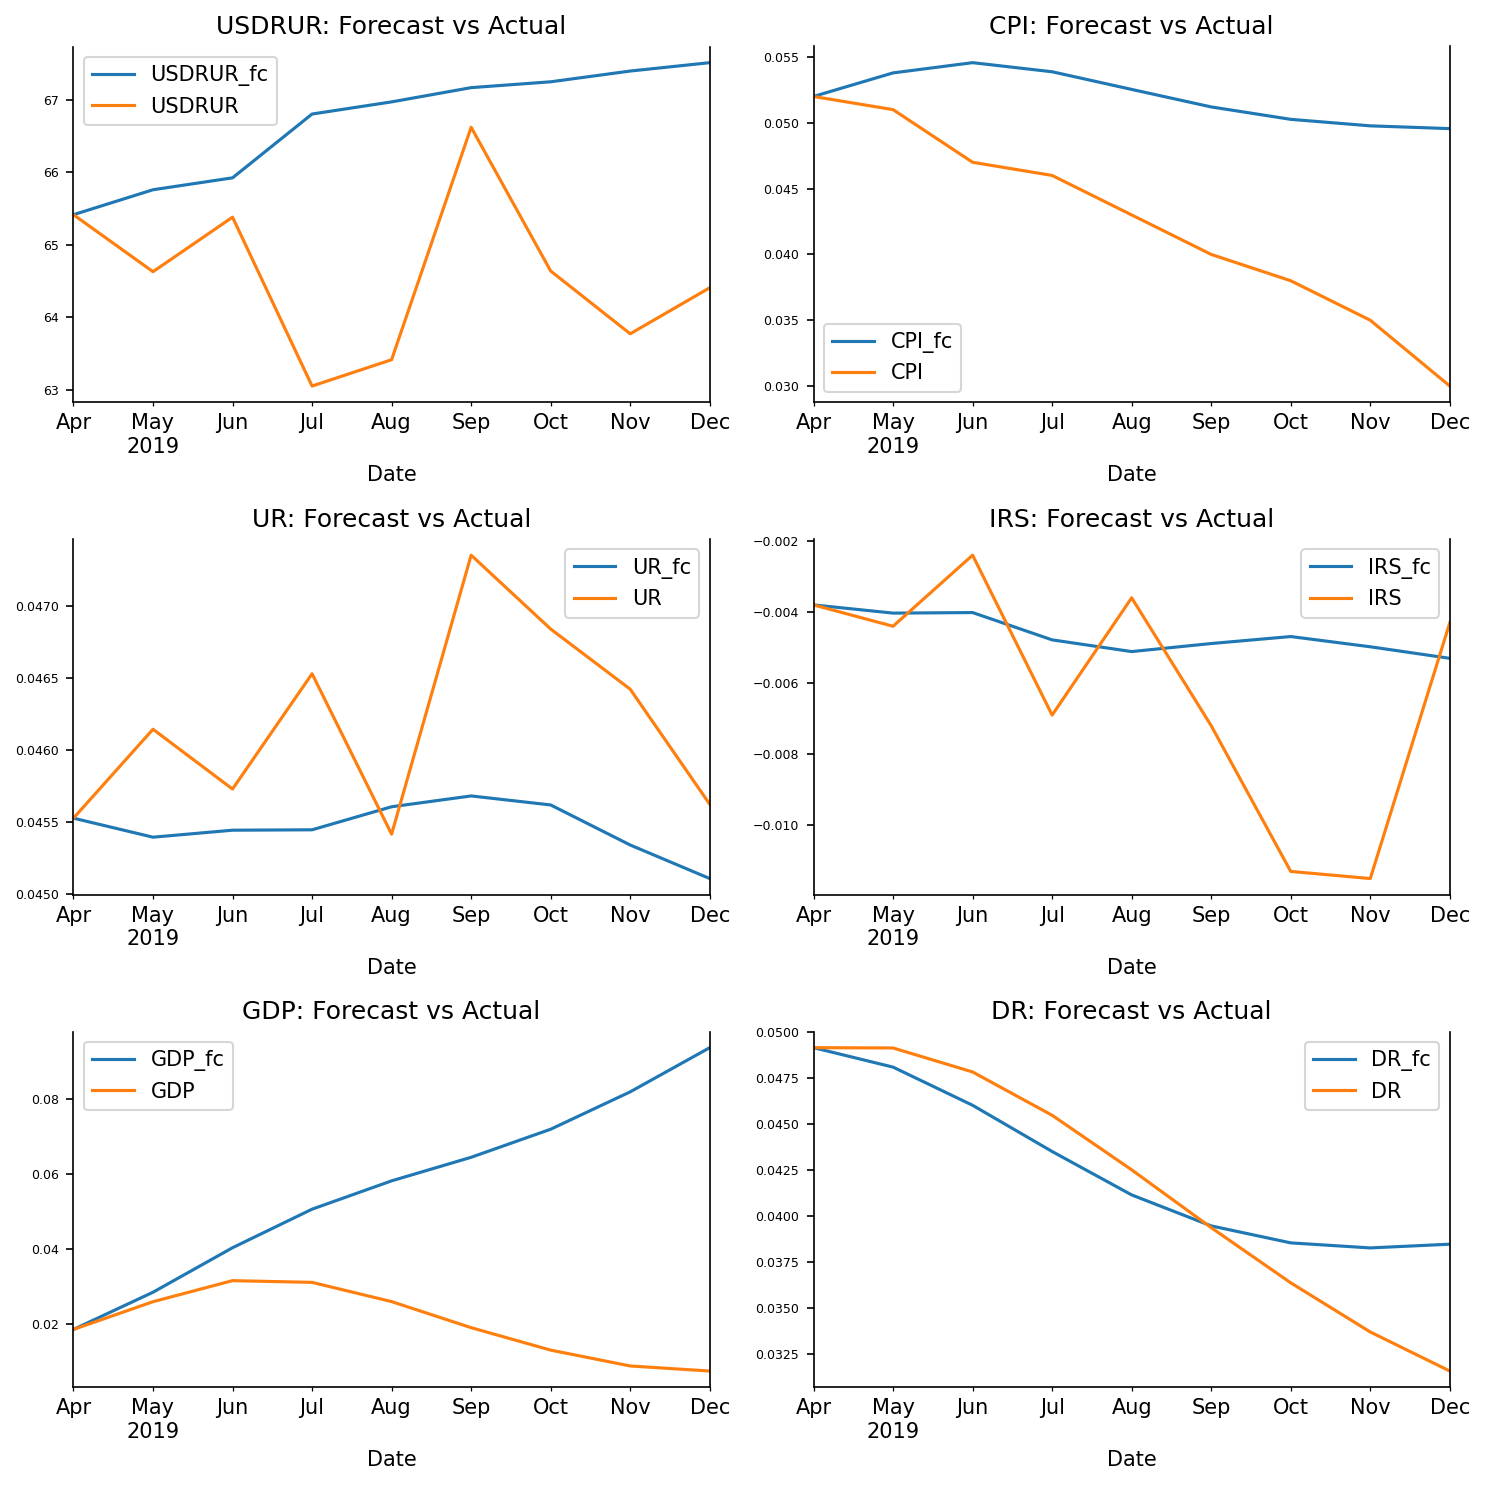

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df_no_HPI.columns, axes.flatten())):
    df_forecast_inv[col+'_fc'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    test[col].plot(legend=True, ax=ax)

    ax.set_title(col + ": Forecast vs Actual")
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();


Точность прогнозов модели VAR(4) для Default Rate <br>
Выбранная спецификация модели обладает хорошим качеством.

In [30]:
def forecast_accuracy(forecast, actual):
    mpe = np.mean((forecast - actual)/actual)   # Mean Percentage Error
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # Mean Abs Percentage Error
    me = np.mean(forecast - actual)             # Mean Error
    mae = np.mean(np.abs(forecast - actual))    # Mean Abs Error
    rmse = np.mean((forecast - actual)**2)**.5  # Root Mean Square Error
    corr = np.corrcoef(forecast, actual)[0,1]   # correlation

    return{'Mean Percentage Error': mpe, 'Mean Abs Percentage Error':mape, 'Mean Error':me,
           'Mean Abs Error': mae, 'Root Mean Square Error':rmse, 'correlation':corr}

accuracy_prod = forecast_accuracy(df_forecast_inv['DR_fc'], test['DR'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))



Mean Percentage Error :  0.0312
Mean Abs Percentage Error :  0.0611
Mean Error :  0.0008
Mean Abs Error :  0.0022
Root Mean Square Error :  0.003
correlation :  0.9352


<h3>VII. Прогнозирование на период 01.2020-12.2022.

Набор фактических и прогнозных данных выбранных макрофакторов на 2020-2022 гг.

In [31]:
df_future = pd.read_csv('data/df_future.csv', parse_dates=['Date'],index_col=0)
df_future = df_future.drop(columns=['HPI'])
df_future

,USDRUR,CPI,UR,IRS,GDP,DR
Date,,,,,,
2020-01-01,61.905700,0.024000,0.044018,-0.009600,0.008675,NaN
2020-02-01,63.138500,0.023000,0.043076,-0.005600,0.008395,NaN
2020-03-01,66.327400,0.025000,0.044875,-0.003600,0.002047,NaN
2020-04-01,76.407400,0.031000,0.056178,-0.013000,-0.013913,NaN
2020-05-01,72.726300,0.030000,0.062548,-0.009800,-0.032341,NaN
2020-06-01,69.711400,0.032000,0.064432,-0.002400,-0.045954,NaN
2020-07-01,70.441300,0.034000,0.065138,-0.011500,-0.047848,NaN
2020-08-01,73.426100,0.036000,0.067590,-0.009500,-0.040969,NaN
2020-09-01,73.803900,0.037000,0.066292,-0.006600,-0.030352,NaN


In [32]:
df_std_by_year_fut = copy(df_future)
for i in df_future:
    df_std_by_year_fut[i] = df_std_by_year[i][-1]

In [33]:
n = 36
lag_order = model_fit.k_ar
forecast_input = df_no_HPI.values[-lag_order:]

fc = model_fit.forecast(y=forecast_input, steps=n)
df_forecast = pd.DataFrame(fc, index=df_future.index[:n], columns=df_future.columns + '_transf')


Предсказанные значения на 2020-2022 гг.

In [34]:
diffed_df_inv_fc = copy(df_future)
normalized_df_inv_fc = copy(df_future)
df_forecast_future_inv = copy(df_future)

for i in df_future:
    diffed_df_inv_fc[i] = stab_inv(df_std_by_year_fut[i], df_forecast[i+'_transf'])
    normalized_df_inv_fc[i] = diff_inv(normalized_df[i][-1:], diffed_df_inv_fc[i])

normalized_df_inv_fc['GDP'] = diff_inv(diffed_df_1['GDP'][-1:], diffed_df_inv_fc['GDP'])
normalized_df_inv_fc['GDP'] = diff_inv(normalized_df['GDP'][-1:], normalized_df_inv_fc['GDP'])

for i in df_future:
    df_forecast_future_inv[i] = norm_inv(df[i], normalized_df_inv_fc[i])

df_forecast_future_inv.columns = df_forecast_future_inv.columns.values + '_fc'
df_forecast_future_inv


,USDRUR_fc,CPI_fc,UR_fc,IRS_fc,GDP_fc,DR_fc
Date,,,,,,
2020-01-01,64.409700,0.030000,0.045620,-0.004300,0.007411,0.031599
2020-02-01,64.627956,0.029625,0.045888,-0.002934,0.003974,0.029515
2020-03-01,64.743576,0.027718,0.045114,-0.002014,-0.001583,0.027595
2020-04-01,64.838078,0.026589,0.044988,-0.002485,-0.008926,0.025857
2020-05-01,65.149241,0.026373,0.044819,-0.001667,-0.016234,0.024647
2020-06-01,65.089352,0.026212,0.044468,-0.001914,-0.022702,0.023739
2020-07-01,65.453639,0.026110,0.044286,-0.002081,-0.028444,0.023175
2020-08-01,65.439608,0.026259,0.044006,-0.002348,-0.034365,0.022848
2020-09-01,65.494007,0.026433,0.043837,-0.002547,-0.041395,0.022662


График актуальных (до 2020 г.) и предсказанных значений (2020-22 гг.) DR

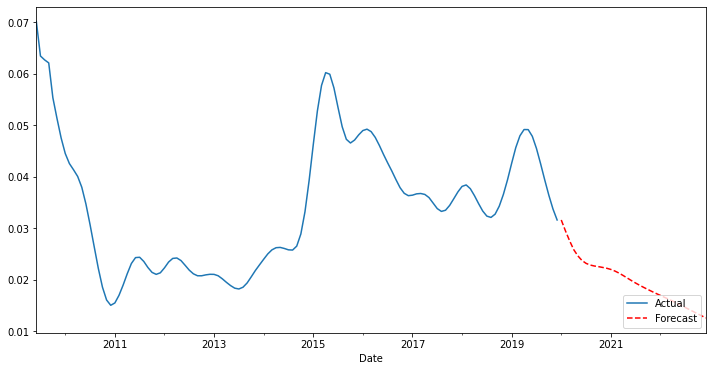

In [35]:
fig, ax = plt.subplots(figsize=(12,6))
df['DR'].plot(ax=ax, style='-', label='Actual')
df_forecast_future_inv['DR_fc'].plot(ax=ax, style='r--', label='Forecast')
legend = ax.legend(loc='lower right')